# Lab 2: Burst Photography

This lab uses sequences of images to composite a new image or to extract some additional information.

Remember you can do aritmetics with images directly when they are loaded as numpy arrays. 



In [2]:
#some magic to show the images inside the notebook
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import ndimage
import imageio as imio
import numpy as np
import subprocess

# A hepler function for displaying images within the notebook.
# It displays an image, optionally applies zoom the image.
def show_image(img, zoom=1.5):
    dpi = 77
    plt.figure(figsize=(img.shape[0]*zoom/dpi,img.shape[0]*zoom/dpi))
    if len(img.shape) == 2:
        img = np.repeat(img[:,:,np.newaxis],3,2)        
    plt.imshow(img, interpolation='nearest')
    

# A hepler function for displaying images within the notebook.
# It may display multiple images side by side, optionally apply gamma transform, and zoom the image.
def show_images(imglist, zoom=1, needs_encoding=False):
    if type(imglist) is not list:
       imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 77 # pyplot default?
    plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        plt.subplot(1,n,i + 1)
        plt.tight_layout()    
        plt.axis('off')
        if len(img.shape) == 2:
           img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.imshow(img, interpolation='nearest')    
    

def saveHDR(filename, image):
    f = open(filename, "wb")
    f.write(str.encode("#?RADIANCE\n# Made with Python & Numpy\nFORMAT=32-bit_rle_rgbe\n\n"))
    f.write(str.encode("-Y {0} +X {1}\n".format(image.shape[0], image.shape[1])))
    
    brightest = np.maximum(np.maximum(image[...,0], image[...,1]), image[...,2])
    mantissa = np.zeros_like(brightest)
    exponent = np.zeros_like(brightest)
    np.frexp(brightest, mantissa, exponent)
    scaled_mantissa = mantissa * 256.0 / brightest
    rgbe = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    rgbe[...,0:3] = np.around(image[...,0:3] * scaled_mantissa[...,None])
    rgbe[...,3] = np.around(exponent + 128)
    
    rgbe.flatten().tofile(f)
    f.close()

def dcraw_meta(path):
    lines = subprocess.check_output(["dcraw", "-i", "-v", path]).decode("utf-8").splitlines()
    lines = [[x.strip() for x in line.split(":", 1)] for line in lines if ":" in line]
    lines = { x[0] : x[1] for x in lines }

    if "Aperture" in lines:
        lines["Aperture"] = float(lines["Aperture"].split("/")[1])

    if "ISO speed" in lines:
        lines["ISO speed"] = float(lines["ISO speed"])

    if "Shutter" in lines:
        shutter = lines["Shutter"].split()[0]
        shutter = shutter.split("/")
        lines["Shutter"] = float(shutter[0]) / float(shutter[1])

    return lines

def getExposureInSeconds(path):
    meta = dcraw_meta(path)
    result = meta["Aperture"] ** 2 / (meta["Shutter"] * meta["ISO speed"])
    return meta["Shutter"]



Populating the interactive namespace from numpy and matplotlib


In [3]:
from subprocess import *
import os
import sys

def opentemp(name="temp",mode='r+b'):
    f=open(name,'w')
    f.close()
    f=open(name,mode)
    return f

def raw2something(path_to_file,output_name,converter_opt=[],dcraw_opt=[]):
    wyn=0
    temppict=output_name
    if "win" in sys.platform:
        try:
            buffor="temp"
            if not converter_opt:
                converter_opt=["magick", buffor,temppict]
            if not dcraw_opt:
                dcraw_opt=["dcraw","-c",path_to_file]
            buffor="temp"
            f=opentemp(buffor,'r+b')
            p1 = Popen(dcraw_opt, stdout=f)
            retcode=p1.wait()
            f.flush()
            p2 = Popen(converter_opt, stdin=f, stdout=PIPE)
            retcode=p2.wait()
            wyn=ndimage.imread(temppict)
            f.close()
            os.remove(buffor)
            #os.remove(temppict)
        except OSError as e:
            print(e)
    else:
        try:
            if not converter_opt:
                converter_opt=["magick","fd:0",temppict]
            if not dcraw_opt:
                dcraw_opt=["dcraw","-c",path_to_file]
            p1 = Popen(dcraw_opt, stdout=PIPE)
            p2 = Popen(converter_opt, stdin=p1.stdout, stdout=PIPE)
            retcode=p2.wait()
            wyn=ndimage.imread(temppict)
            f.close()
            os.remove(temppict)
        except OSError as e:
            print(e)
    return wyn

def raw2JPG(path_to_file):
    if "win" in sys.platform:
        return raw2something(path_to_file,"temp.jpg")
    else:
        return raw2something(path_to_file,"temp.jpg",["cjpeg", "-outfile temp.jpg"])

def extract_raw(path_to_file):
    return raw2something(path_to_file,"temp.pgm")

def raw2linear_tiff(path_to_file):
    return raw2something(path_to_file,"temp.tiff",dcraw_opt=["dcraw","-T","-6","-d","-c",path_to_file])

## Task 1: HDR (20)

You are given a sequence of images in RAW format. Use dcraw to convert them to a linear 16 bits
tiff. Merge these images using the formula from Robertson’s method (below). In order to load these images, you can use imageio, which works the same as ndimage, but supports tiff 16 and HDR images. (Note that values are not between 0 and 255 in this case). 

You need to get the exposure time of your images from the EXIF metadata. You can do this using DCRAW, you are given a function for this.

Robertson’s method is actually more complicated, but for us, we will simply apply this weighting. Normalize the values between 0 and 1 before doing operations on them.
Save the result an HDR image. Save it as an EXR image or HDR format. You are given some code
to save the file in HDR format. You can try to use OpenEXR bindings in python, OpenCV also supports EXR.


Robertson's: ![Alt](./hdr7.png "Title")

Individual exposure (image value $I_{linear}$) is radiance (X) * exposure time (t):

$I_{lin} = tX$

### Memorial Sequence

You have a sequence of the Memorial Dataset. We do not have the camera response curve for this dataset, so the merging will probably suffer some artefacts. You can approximate the camera response curve with a gamma correction.
As an extra exercise, you can take the code from the last cell in this jupyter notebook to work with this sequence so you estimate the camera response curve.


### Opening your HDR images. 
HDR formats start to be supported by operative systems, but typically you will see a tonemapped version of the image. A nice tool is the Luminance software, http://qtpfsgui.sourceforge.net/?page_id=10 which allows you to open and modify HDR images. It also includes several tonemapping opperators.

### Take your own sequence (If you can)

You will need a tripod and a camera where you can change the exposure time. Set it to bracket more with the longer number of exposures possible. 

### Display radiance (luminance) in false color (blue to red)

https://matplotlib.org/users/image_tutorial.html

In [3]:
path="./HDR/sec1/"
img1=raw2JPG(path+"_MG_4460.CR2")
img2=raw2JPG(path+"_MG_4461.CR2")
img3=raw2JPG(path+"_MG_4462.CR2")
img1=img1/float(2**8)
img2=img2/float(2**8)
img3=img3/float(2**8)

In [4]:
newpath="./HDR/sec1/_MG446"
images=[newpath+str(x)+".CR2" for x in range(3)]
sizeim=len(images)

def loadimages(tab,mode="jpg"):
    if mode=="jpg":
        wyn=[raw2JPG(x) for x in tab]
    if mode=="tiff":
        wyn=[raw2linear_tiff(x) for x in tab]
    return wyn

In [5]:
t=range(0,3)
t[0]=1/8.
t[1]=1/30.
t[2]=1/2.
w = lambda x: np.exp(-4.*((x-.5)**2)/(0.5**2))
ilin = lambda x, t: t*x

Ilin=range(0,3)

In [6]:
Ilin[0]=ilin(img1,t[0])
Ilin[1]=ilin(img2,t[1])
Ilin[2]=ilin(img3,t[2])
#print(Ilin)

In [7]:
W=range(0,3)
for i in range(0,3):
    W[i]=w(Ilin[i])

In [8]:
X1=t[0]*Ilin[0]*W[0]
X2=W[0]*t[0]**2.
for i in range(1,3):
    X1+=W[i]*Ilin[i]*t[i]
    X2+=W[i]*t[i]**2
    
X=np.clip(X1/X2,0.,1.)

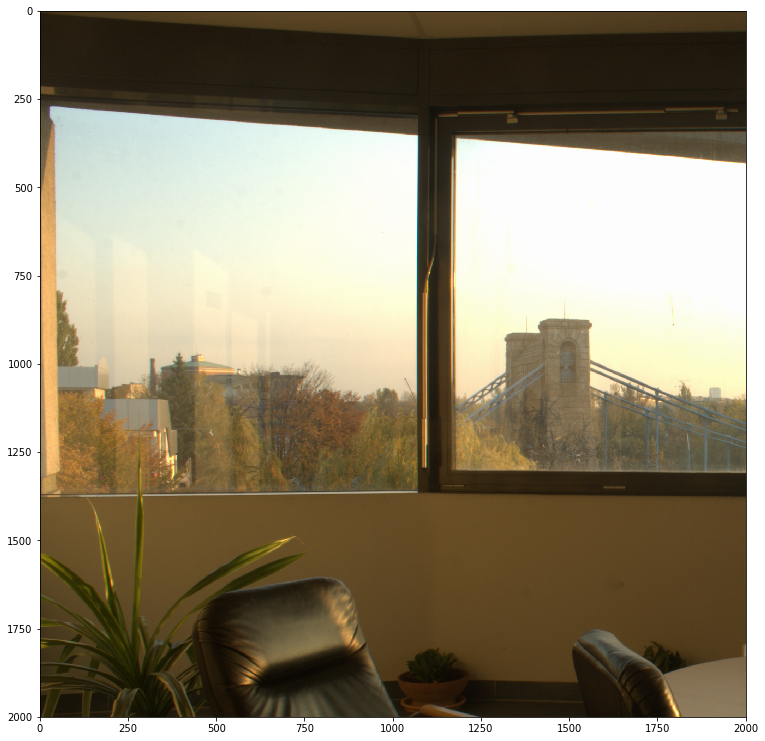

In [9]:
show_image(X[:2000,:2000],0.5)

## Task 2: Tone Mapping (40)

We will do a simple implementation of the Bilateral Filter Tone Mapping algorithm seen in class.
http://people.csail.mit.edu/fredo/PUBLI/Siggraph2002/
You can use the opencv bilateral filter implementation. You can also find details on the gradient based tone mapping commented in class here: http://www.cs.huji.ac.il/~danix/hdr/hdrc.pdf

A more comprehensive list of tone mapping algorithms can be found [here](https://www.google.pl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=4&cad=rja&uact=8&ved=0ahUKEwjr_OGauo7XAhXK6xoKHXG5AhQQFghAMAM&url=http%3A%2F%2Fcadik.posvete.cz%2Ftmo%2F&usg=AOvVaw0kU5sdvkmnR5zky_4EQDCz). 

### This method

The basic idea is to get intensity of the image, take its log, and apply the bilateral filter. Then divide
the log(intensity) by the filtered image and do some contrast correction. Then, take the inverse of
the log, and multiply by the color ratios.

Here is the high-level set of operation that you need to do in order to perform contrast reduction

```python
#pseudocode
input intensity= 1/61(R*20+G*40+B)
r=R/(input intensity), g=G/input intensity, B=B/input intensity
log(base)=Bilateral(log(input intensity))
log(detail)=log(input intensity)-log(base)
log (output intensity)=log(base)compressionFactor+log(detail) - log_absolute_scale
R output = r*10^(log(output intensity)), etc.
```

#### Note from the authors
You can replace the first formula by your favorite intensity expression.
You can replace the multiplication by compressionfactor by your favorite contrast-reduction curve
(e.g. histogram adjustment, Reinhard et al.'s saturation function, etc.)

compressionfactor and log_absolute_scale are image-dependent.

compressionfactor makes sure the contrast matches a given target contrast. It is the ratio of this target and the contrast in the base layer:

```python
#pseudocode
targetContrast/(max(log(base)) - min(log(base)))
```
I use log(5) as my target, but you can use a bigger value to preserve more contrast.
log_absolute_scale essentially normalizes the image, by making sure that the biggest value in the
base after compression is 1. 

It is equal to $max(log(base))*compressionfactor$
All log are in base 10.


Use Luminance HDR software to load and compare the results with yours. Explore the different
tone mappers and their differences. You can also use this software to create, load and compare
your results.

[[[ 67  63  38]
  [ 66  62  37]
  [ 69  65  38]
  ..., 
  [ 97  88  57]
  [ 98  89  58]
  [ 99  90  59]]

 [[ 54  49  29]
  [ 55  50  30]
  [ 57  52  32]
  ..., 
  [ 99  90  59]
  [ 99  90  59]
  [ 99  90  59]]

 [[ 44  41  26]
  [ 45  42  27]
  [ 46  43  28]
  ..., 
  [100  91  62]
  [ 99  90  61]
  [ 99  90  61]]

 ..., 
 [[ 59  64  24]
  [ 52  56  19]
  [ 50  54  17]
  ..., 
  [181 177 165]
  [179 175 163]
  [178 174 162]]

 [[ 58  60  21]
  [ 50  54  17]
  [ 50  54  19]
  ..., 
  [180 176 164]
  [179 175 163]
  [178 174 162]]

 [[ 56  58  21]
  [ 49  53  16]
  [ 49  53  18]
  ..., 
  [180 176 165]
  [180 176 165]
  [180 176 165]]]


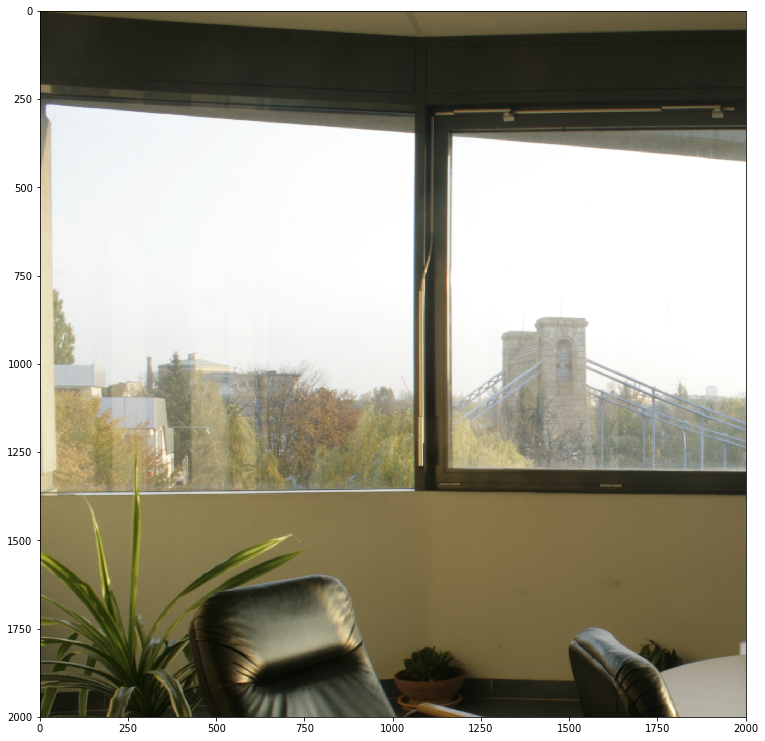

In [6]:
X=ndimage.imread("/home/michal/CmpPh/Lab2/HDR/sec1/_MG_4462.JPG")[:2000,:2000]
print X
show_image(X[:2000,:2000],0.5)

In [7]:
import cv2
copyX=copy(X)


In [8]:
"""
#pseudocode
input intensity= 1/61(R*20+G*40+B)
r=R/(input intensity), g=G/input intensity, B=B/input intensity
log(base)=Bilateral(log(input intensity))
log(detail)=log(input intensity)-log(base)
log (output intensity)=log(base)compressionFactor+log(detail) - log_absolute_scale
R output = r*10^(log(output intensity)), etc.
"""
def bilateral_filter_tone_mapping(img):
    imshape=img.shape
    img=img.astype(float)
    temp=np.ones(imshape[:2])
    intensity = lambda (r,g,b): (r*20.+g*40.+b)/61.
    for i in range(imshape[0]):
        for j in range(imshape[1]):
            temp[i][j]=intensity(img[i,j])
            for k in range(3):
                img[i,j,k]=img[i,j,k]/temp[i,j]
                
    temp=np.log10(temp).astype(uint8)
    #print(temp)
    logbase=cv2.bilateralFilter(temp,d=-1,sigmaColor=20., sigmaSpace=20.).astype(float)
    #print(logbase)
    compressionfactor=np.log10(5)/(np.max(logbase) - np.min(logbase))
    #print(compressionfactor)
    logdetail=temp-logbase
    logoutint=logbase*compressionfactor+logdetail-(np.max(logbase)*compressionfactor)
    for i in range(imshape[0]):
        for j in range(imshape[1]):
            for k in range(3):
                img[i,j,k]=img[i,j,k]*10**logoutint[i,j]
    img=np.clip(img,0.,1.)
    #print(temp)
    return img


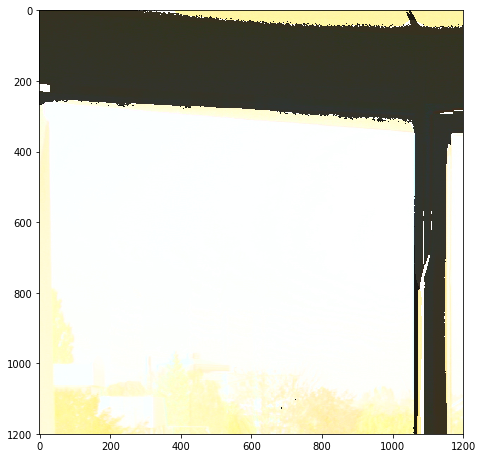

In [9]:
copyX=copyX[:1200,:1200]
#
copyX=bilateral_filter_tone_mapping(copyX)
#show_image(X[:2000,:2000],0.5)
#print(copyX)
show_image(copyX,0.5)

# Focal Stack

If you try to capture your own sequence, you will notice that there is a small change in magnification that occurs as you change the focus. This is due to the change of focal length that happens when adjusting focus.
These sequences need to be compensated for this small change in magnification.

I did this with the sequence fs1 using Hugin (http://hugin.sourceforge.net/) software, there is a sub-application for aligning images. Here a tutorial https://patdavid.net/2013/01/focus-stacking-macro-photos-enfuse.html



## Task 4: All in Focus Image (20)

Compute an all-in-focus image from a focal stack. Images of a focal stack are provided with focuses at different focal planes.

I would recommend you to start with the "sim" sequence. The fs1 sequence has not been tested. The other sequences come from this paper, which uses a more sophisticated approach [Moeller 2015](https://github.com/adrelino/variational-depth-from-focus). Here another paper on the topic if you want to learn more [Jacobs et al. 2012](https://graphics.stanford.edu/papers/focalstack/)

The idea is to estimate for each pixel in which image is more in focus. This will only work on areas where there is texture/detail. Two simple approaches are to use the first derivative or the second derivative of a gaussian (Laplacian) to measure the sharpness of the image in a particular pixel. You should use a single channel (or combination of them), rather than the 3 channels separately. 

Fuse all three images by picking the pixel value with the highest gradient magnitude or bigger response to the Laplacian among all images. Plot an false color image with the image contributions. 

Computing Gradient: 
You can have a look to ndimage.filters. You can try gaussian filters with first and second derivatives and different sigmas, the laplacian, and gradient magnitude, and obseve the results.  

Also, you can define your own kernel and use convolutions with a simple 3x3 kernel.

https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm

## Task 5: Depth from Focus (20)

Using the same method, create a depth image assigning depths to the pixels depending on their focal plane. This will be blocky/noisy. You can check with some of the filters that we used so far (Gaussian/Median/Bilateral) to improve the depth map. Display the depthmap using a false color scheme (blue to red). 

https://matplotlib.org/users/image_tutorial.html

## EXTRA: Curve Response Estimation

This is some code translation from the [Devebec and Malik](http://www.pauldebevec.com/Research/HDR/debevec-siggraph97.pdf) paper on HDR imaging. The paper has some Matlab code at the end, if you find some bug in my code, let me know. You can adapt it to work with more images to make it work with the Memorial dataset.



In [3]:
def w(z):
    return 128. - abs(z-128.)

def gsolve(Z,B,l):
    n = 256 # ?
    
    print (Z.shape[1])
    
    A = np.zeros((Z.shape[1]*Z.shape[0]+n+1, n + Z.shape[1]))
    b = np.zeros((A.shape[0],1))
    
    print (A.shape)    
    print (b.shape)
    print (Z.shape[1])
    print (Z.shape[0])
    
    k = 0
    for i in range(Z.shape[1]):
        for j in range(Z.shape[0]):
            wij = w(Z[j,i]+1)
            A[k, Z[j,i]] = wij
            A[k, n+i] = -wij
            b[k] = wij * B[j]
            k = k+1
    
    A[k,127] = 1.
    k = k+1
    
    #print (A)
    
    for i in range(n-1):
        A[k,i] = l*w(i+2)
        A[k,i+1] = -2.*l*w(i+2)
        A[k,i+2] = l*w(i+2)
        k=k+1
    
    x = np.linalg.lstsq(A, b)[0]
    #print (x.shape)
    g = x[0:n]
    lE = x[n:x.shape[0]]
    return (g,lE)
        

def debevecMalik(probe0,probe1,probe2,output,B, l):
    #get pixesl for Z
    result = np.zeros(probe0.shape)
    gamma = range(256)
    n = 256 # maybe not
    gamma = np.power(np.divide(gamma,255),2.2)*8.
    #samples some pixels
    ys = np.random.randint(probe0.shape[0], size=(50))
    xs = np.random.randint(probe0.shape[0], size=(50))   
    
    for c in range(3):
        samples = []
        ss = 0
        for y,x in zip(ys,xs):
            check_under = probe0[y,x,c]
            check_over  = probe2[y,x,c]
            if (check_under < 1. or check_over > 254):
                ss = ss +1
            samples.append((y,x,c))
        
        print ("Saturated samples ", ss)
        Z = np.zeros((3,len(samples))).astype(int)
        for i,s in enumerate(samples):
            Z[0,i] = float(probe0[s])
            Z[1,i] = float(probe1[s])
            Z[2,i] = float(probe2[s])
        
        g, lE = gsolve(Z,B,l)
              
        if c == 1:
            plot(g,range(n))

        for y in range(probe1.shape[0]):
            for x in range(probe1.shape[1]):
                z0 = probe0[y,x,c]
                z1 = probe1[y,x,c]
                z2 = probe2[y,x,c]
                value = w(z0)*(g[z0] - B[0]) + w(z1)*(g[z1] - B[1]) + w(z2)*(g[z2] - B[2])
                ws = w(z0)+w(z1)+w(z2)
                result[y,x,c] = math.exp(value/ws)
                
    #print (g)
    saveHDR(output, result)